# Summer internship 

This notebook presents a code based on the research papper: "Euclid preparation: VII. Forecast validation for Euclid cosmological probes" in which the objective is to calculate de asocciated error of cosmological parameteres meassurements using the Fisher Matriz formalisim for forcasting probes. 

I suggest reading the pappers found on the folder titled "Research Pappers/" and instaling CAMB. For more information, visit https://camb.info/.

In [19]:
# necessary package import for code 

import sys
import os
import numpy as np
import scipy.integrate as integrate
import camb as camb
from matplotlib import pyplot as plt
from scipy.stats import binned_statistic
import time
from camb import model
import pandas as pd
from astropy import constants as const
import mpmath



# CAMB 

This section shows the intalation of CAMB and a basic familarization with CAMB packages and their usses.

In [3]:
# camb instalation

camb_path = os.path.realpath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, camb_path)


print('Using CAMB %s installed at %s'%(camb.__version__, os.path.dirname(camb.__file__ )))

Using CAMB 1.3.6 installed at c:\ProgramData\Anaconda3\lib\site-packages\camb


# Cosmological Context

It is necessary for the comprehension of this internship to present the cosmological context in which the work will be done. For this purpose, I'll summarize the core theory, beggining with the description of the different **comsmological models and their asocciated parameters** that are important to us in this context.

## Background quantities 

Based on Einstein's field equations of **general relativity**, it is possible to derive the Friedmann equations which govern the expansion of space and describe the time evolution in homogeneus and isotropic models of the universe. The equations are: 

$H^2(t) = [\frac{\dot{a(t)}}{a(t)}^2] = \frac{8\pi G}{3}\rho(t) - \frac{Kc^2}{a^2(t)} \\$
$\frac{\dot{a(t)}}{a(t)} = -\frac{4\pi G}{3}[\rho(t) + 3\frac{\rho(t)}{c^2}$

Adding **redshift** as a scale factor; $z=a_0/a-1$ and normazalizing $a_0 =1$ which denotrs the present day valur of the scale factor, the **Hubble expassion rate $H(z)$** can be expressed as follows: 
$H(z) = H_0E(z)$ where $H_0$ is the Hubble parameter today, and $E(z)$ is the proper distance function.

To define **cosmological parameters** and work efficiently with them, we can definde the **density parameter** $\Omega_i(z) = \rho_i(z)/\rho_{crit}(z)$ where $ \rho_{crit}(z)$ is the critical density, derived from the Hubble expanssion rate and a spattialy flat geometry (K=0), and $i$ denotes a generic component. By also defining an **effective curvature density** parameter $\Omega_K(z)$, equation 1 takes de form:

$\sum_{i=1}^{N} \Omega_i(z) + \Omega_K(z) = 1$ whew the sum is over all N species consider in the model.

The Friedmann equations can be combined into an **energy conservation equation**. A solution of this equation requires to specify the properties og each energy component in the form of a equation of state $p=p(\rho)$ that is specified in terms of state parameters $w = p/\rho c^2$, which can be redshift dependent. 



In [12]:
# valores de Planck 2016 para testear las funciones

params_P18 = dict()
# crearemos diccionarios en donde estaran los parametros cosmologicos que
# queremos utilizar, es facil poder crear y modificar diccionarios

params_P18['Ob'] = 0.05   # Omega_b_0
params_P18['Om'] = 0.32  # Omega_m_0
params_P18['ns'] = 0.96605       # indice espectral
params_P18['ODE'] = 0.68   # Omega_DE_0
params_P18['sigma8'] = 0.816    # amplitud de densidades de fluctuación
params_P18['H0'] = 67.32      # 100h
params_P18['sum_mv'] = 0.06  # valor de masas de neutrino
params_P18['w_0'] = -1
params_P18['w_a'] = 0
params_P18['gamma'] = 0.55
params_P18['Ov'] = 0  # en este caso tomamos la densidad de radiación como nula


# Creacion de parametros con CAMB

pars = camb.CAMBparams()

# This function sets up CosmoMC-like settings, with one massive neutrino and
# helium set using BBN consistency

pars.set_dark_energy(w=-1.0, wa=0, dark_energy_model='fluid')
pars.set_cosmology(H0=67.4, ombh2=0.02233, omch2=0.1198, omk=0, tau=0.054)
results = camb.get_results(pars)

params_CAMB = dict()
# crearemos diccionarios en donde estaran los parametros cosmologicos que
# queremos utilizar, es facil poder crear y modificar diccionarios

params_CAMB['Ob'] = results.get_Omega('baryon')
params_CAMB['Om'] = 1 - pars.omk - results.get_Omega('de')
params_CAMB['ODE'] = results.get_Omega('de')
params_CAMB['H0'] = pars.H0
params_CAMB['w_0'] = pars.DarkEnergy.w
params_CAMB['w_a'] = pars.DarkEnergy.wa
params_CAMB['Ov'] = results.get_Omega('photon')

# cration of basic background quantities

We base our models in the **standard model of cosmology:** $\Lambda CDM$, we can now define basic background quantities for this model which will define our future work:

The **matter energy density** in the form of baryons and cold dark matter particles will be describe by: $w_b = w_c = 0$. The photon radiation density is $w_{\gamma} =1/3$. For the purpouse of galaxy clustering and weak lensing measurements the radiation density $\Omega_{\gamma,0}$ is neglible. and we treat massive neutrinos as part of the total matter contribution: $\Omega_{m,0} = \Omega_{c,0} + \Omega_{b,0} + Omega_{v,0}$. 
In this context, cosmic acceleration requieres a fluid, with this we mean "dark energy" (DE) which has an equation of state $w_{DE} < -1/3$. Our model, assumes that this phenomenom is due to the pressence of the cosmological constant $\Lambda$ described by the equation of state $w_{\Lambda} = -1$ which corresponds to a time independent energy density $\rho_{\Lambda}$.


In [13]:
def Omega_Lambda(Omega_m, Omega_b, Omega_v):
    """La funcion Omega_Lambda nos entregara este parametro en base a los que
    tenemos, para esto tambien debemos calcular Omega c, un parametro que
    no se utilizara, por lo que no es necesario almacenar"""
    Omega_c = Omega_m - Omega_b
    OL = 1 - Omega_c - Omega_b - Omega_v
    return OL


def Omega_K_0(Omega_DE, Omega_m):
    """Omega_K_0 nos entrega este parametro que es depende de Omega DE y
    Omega m, en el caso de del modelo ΛCDM este valor es cero"""
    OK = 1 - (Omega_DE + Omega_m)
    return OK


def cosmological_parameters(cosmo_pars=dict()):
    """cosmological_parameters extrae los parametros necesarios para las
    el calculo de funciones E(z) y D(z), concadena estos parametros de manera
    que sean facil de utilizar, el default son los parametros de Planck 2018"""
    H0 = cosmo_pars.get('H0', params_P18['H0'])
    Om = cosmo_pars.get('Om', params_P18['Om'])
    Ob = cosmo_pars.get('Ob', params_P18['Ob'])
    Ov = cosmo_pars.get('Ov', params_P18['Ov'])
    ODE = cosmo_pars.get('ODE', params_P18['ODE'])
    OL = Omega_Lambda(Om, Ob, Ov)
    OK = Omega_K_0(ODE, Om)
    wa = cosmo_pars.get('wa', params_P18['w_a'])
    w0 = cosmo_pars.get('w0', params_P18['w_0'])
    return H0, Om, ODE, OL, OK, wa, w0

## Proper Distance Function $E(z)$ and Angular Diameter Distance Function $D(z)$

**Proper distance** and **Comoving distance** are two closely related distance measures used to define distances between objects.

Proper distance roughly corresponds to where a distant object would be at a specific moment of cosmological time, which can change over time due to the expansion of the universe. 

Comoving distance factors out the expansion of the universe, giving a distance that does not change in time due to the expansion of space, though this may change due to other, local factors, such as the motion of a galaxy within a cluster.

The  $\Lambda CDM$ model has fudamental problems, although it fits observations very well. This problems are known as: **The cosmological constant problem** and **The coincidence problem**. Because of this the model and its parameters cannot be predicted from physicial principles. 
It is needed a general scenarios for the component responsible for cosmic acceleration. This scenario postulates a **dynamical DE** with a redshift dependent equation of state parameter: 
$w_{DE}(z) = w_0 + w_a\frac{z}{1+z}$ with $w_0$ the present value of the equation of state and $w_a$ a meassure of its time variation.

In this case,the evolution od DE density obbeys: 
$\rho_{DE}(z) = \rho_{DE,0}(1+z)^{3(1+w_0+w_a)}exp[-3w_a\frac{z}{1+z}]$

Finally it is possible to denife the **proper distance function** $E(z)$ as:

$E(z) = \sqrt{\Omega_{m,0}(1+z)^3 +\Omega_{DE,0}(1+z)^{3(1+w_0+w_a)}exp[-3w_a\frac{z}{1+z}] + \Omega_{K,0}(1+z)^2}$

Where it is possible to recover the setting of the $\Lambda CDM$ model by setting $w_0 = -1$ and $w_a = 0$, in which case the proper distance function become;

$E(z) = \sqrt{\Omega_{m,0}(1+z)^3 +\Omega_{\Lambda,0}+ \Omega_{K,0}(1+z)^2}$


The comoving distance to an object redshift z can be computed as:

$r(z) = \frac{c}{H_0}\int_{0}^{z} \frac{dz}{E(z)}$

From comoving distance we can derive the **angular diameter distance** $D_A(z)$ which is the relation between the apparent angular size of an object and its true physical size in Euclidean space. The function is defined as:

   
$D_A(z) = 
     \begin{cases}
       (1+z)^{-1}\frac{c}{H_0}\frac{1}{\sqrt{|\Omega_{K,0}|}}sin[\sqrt{|\Omega_{K,0}|}\frac{H_0}{c}r(z) &\quad\text{if } \Omega_{K,0}\leq 0\\
       (1+z)^{-1}r(z) &\quad\text{if }\Omega_{K,0} =0 \\
       (1+z)^{-1}\frac{c}{H_0}\frac{1}{\sqrt{\Omega_{K,0}}}sin[\sqrt{\Omega_{K,0}}\frac{H_0}{c}r(z) &\quad\text{if } \Omega_{K,0}\geq 0\\
     \end{cases}    $

In [14]:
def E_arb(z, cosmo_pars=dict()):
    """E_arb es la función E(z) arbitraria para cualquier modelo cosmologico"""
    H0, Om, ODE, OL, Ok, wa, w0 = cosmological_parameters(cosmo_pars)
    exp = np.exp(-3*wa*(z/1+z))
    ind = 1 + wa + w0
    E = np.sqrt(Om*(1+z)**3 + ODE*((1+z)**(3*ind))*exp + Ok*(1+z)**2)
    return E


def E(z, cosmo_pars=dict()):
    """E es la función E(z) para el caso w0 = -1 y wa = 0"""
    H0, Om, ODE, OL, Ok, wa, w0 = cosmological_parameters(cosmo_pars)
    E = np.sqrt(Om*(1+z)**3 + OL + Ok*(1+z)**2)
    return E

In [24]:
# comoving distance to an object redshift z

def f_integral(z, cosmo_pars=dict()):
    """f_integral define la funcion dentro de la integral
    ocupada para el calculo de r(z)"""
    return 1/E_arb(z, cosmo_pars)


def r(z, cosmo_pars=dict()):
    """r calcula comoving distnace to an objecto redshift"""
    c = const.c.value / 1000
    cte = c/params_P18['H0']  # h^-1 Mpc
    int = integrate.quad(f_integral, 0, z, args=cosmo_pars)
    return cte*int[0]


# transverse comoving distance


def D(z, cosmo_pars=dict()):
    """La funcion D calcula transverse comoving distance para los distintos
    casos de el parametro Omgea_K_0"""
    c = const.c.value
    H0, Om, ODE, OL, Ok, wa, w0 = cosmological_parameters(cosmo_pars)
    cte_1 = c/H0
    cte_2 = H0/c
    a = 1/(1+z)
    if Ok < 0:
        return a*(cte_1*(1/(np.abs(Ok)**(1/2))))*np.sin(
            np.abs(Ok)**(1/2)*cte_2*r(z, cosmo_pars))
    if Ok == 0:
        return a*r(z, cosmo_pars)
    if Ok > 0:
        return a*(cte_1*(1/(Ok**(1/2))))*np.sinh(
            (Ok**(1/2))*cte_2*r(z, cosmo_pars))
    else:
        return "Error"

In [17]:
class Memoize:
    def __init__(self, f):
        self.f = f
        self.memo = {}
    def __call__(self, *args):
        if not args in self.memo:
            self.memo[args] = self.f(*args)
        #Warning: You may wish to do a deepcopy here if returning objects
        return self.memo[args]

El tiempo que se demoró es 0.08175945281982422 segundos
El tiempo que se demoró es 0.05884814262390137 segundos


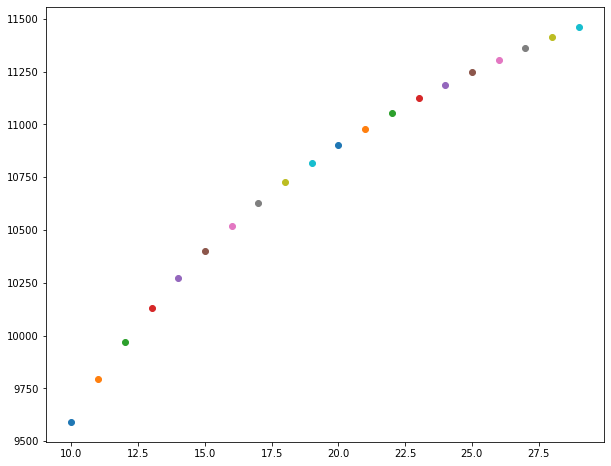

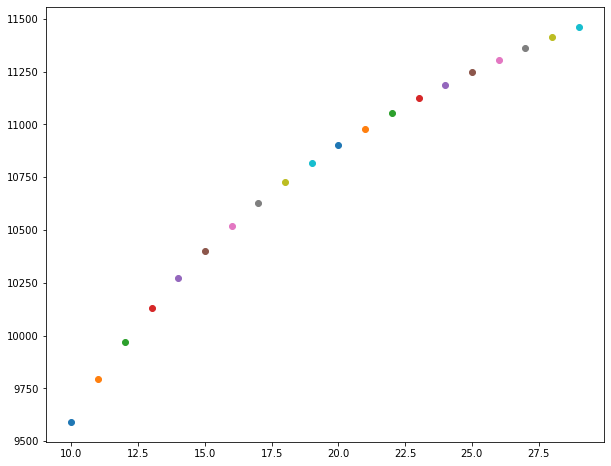

In [32]:


def r_1(z, cosmo_pars=dict()):
    """r calcula comoving distnace to an objecto redshift"""
    c = const.c.value / 1000
    cte = c/params_P18['H0']  # h^-1 Mpc
    int = integrate.quad(f_integral, 0, z, cosmo_pars)
    return cte*int[0]





st_1 = time.time()
fig, ax = plt.subplots(1, 1, sharey='row', sharex='col', figsize=(10, 8))
z = np.arange(10, 30)
for l in z:
    ax.scatter(l, r_1(l))
fig.show
en_1 = time.time()
print("El tiempo que se demoró es "+str(en_1-st_1)+" segundos")

st_2 = time.time()
fig, ax = plt.subplots(1, 1, sharey='row', sharex='col', figsize=(10, 8))
z = np.arange(10, 30)
for l in z:
    ax.scatter(l, r(l))
fig.show
en_2 = time.time()
print("El tiempo que se demoró es "+str(en_2-st_2)+" segundos")

# Linear Perturbations 
The structure we see today on large scales grew from miniute density fluctuations generated by a random process in the primordial Universe. The evolution of these fluctuations can be described by ideal fluid equations. Density fluctuations for a given component $i$ are characterised by the density constrast which quantifies the deviations of the density field $\rho _i(x,z)$ around the mean spatial density $\bar{\rho _i}(z)$ over the space by:  

$\delta _i(x,z) \equiv \rho _i(x,z)/ \bar{\rho _i(z)} -1$ where $x$ is three dimensional comoving coordinate at a redshift $z$.

It is better to decompose $\delta$ into plane waves to describe these fluctions statistically: 

$\delta _i(x,z) = \int \frac{d^3k}{(2\pi)^3} \tilde{\delta} _i (k,z)exp(ik \dot x)$

We can define de **power spectrum**, under the assumptions of statistical homogeneity and isotropy, by only depending on $k = \abs{k}$ and z:

$\langle \tilde{\delta}_i(k,z)\tilde{\delta '}_i(k,z)\rangle = (2\pi)^3\delta _D(k +k')P_i(k,z)$

In the early Universe during eadiation domination, curvature perturbations with cmoving scales smaller then the horizon are suppressed, whereas super-horizon fluctuations remain unaffected, until they enter the horizon. In the matter dominated era, curvature perturbations on all scales remain constant. This mean that a caracteristing scale corresponding to the epoch of matter-radiation  equality is imprinted on the shape of the power spectrum.

The growth density fluctuations obeys the following second order diferrential equatios:

$ddot{\delta}_m(k,z) + 2H\dot{\delta}_m(k,z) - \frac{3H_0^2\Omega _{m,0}}{2a^3}\detla _m(k,z)$
during matter domination we can consider matter as a pressurles ideal fluid and so the ODE can be equal to zero. Moreover in te $\Lambda CDM$ scenario with no massive neutrinos, this equation can be written as: 

$\delta _m ''(k,z) + [\frac{H'(z)}{H(z) - \frac{1}{1+z}}\delta _m '(k,z) - \frac{3\Omega _m (z)}{2(1+z)^2}\delta _m(k,z)] = 0 $

The solutions $\delta _m (k,z)$ tho this equation can be, at late time, scale-independent, this motivates the introduction of the growth factor $D(z)$; $\delta _m(k,z) = \delta _m(k,z_i)\frac{D(z)}{D(z_i)}$, where $z_i$ is the arbitrary reference redshift in the matter dominant era. The growth parameter satisfies a first order differential equation, derived from this we can express $D(z)$ as:

$D(z) = D(z=0)exp[-\int_0^z dz' \frac{f(z')}{1+z}]$

is is possible to observe that in $\Lamda CDM$ we can define the growth rate $f(z)$ as:

$f(z) = |\Omega _m(z)|^{\gamma}$, with a constant growth index parameter $\gamma \sim 0/55$ and defining the matter density as: $\Omega _m (z) = \frac{\Omega_{m,0}(1+z)^3}{E^2(z)}$

In $\Lambda CDM$ the late-time matter growth is scale-independent, thanks to this the transfer function $\Tau _m(k,z)$ can be split inyo a scale dependent part $T_m(k)$ and the scale independent growth factor introduced before. Now we can redifined the power spectrum for matter as:

$P_{\delta \delta}(k,z) = (\frac{\sigma _8}{\sigma _N})^2[\frac{D(z)}{D(z=0)}]^2 T_m^2(k)k^{n_s}$

with the normalization constant:

$\sigma_N^2 = \frac{1}{2\pi^2} \int dk T_m^2(k)|W_{TH}(kR_8)|^2k^{n_s +2}$ with $W_{TH}(x) = 3(sinx- xcosx)/x^3$ the Fourier transform of the top-hat filter, and $R_8 = 8H^{-1} Mpc$

the root mean square (rms) of present dat linearly evolved density fluctions in speheres give us:

$\sigma _8^2 = \frac{1}{2\pi^2} \int dk P_{\delta \delta}(k, z=0)|W_{TH}(kR_8)|^2k^2$
note that for a more realistic modified gravity models, a constant frowth index is too restrictive if scale depence exists.

# Recipe for Weak Lensing

The large scale cosmic sctructure deflects the path photons from distant galaxies, which induces distortions in the images of these galaxies. Locally such distortions can be decomposed at the linear level into convergence and a complex shear distortion, which are respectively related to magnification and shape distortion of the image. 

The shear field caused by large-scale strucutre has a zero mean beacuse we assume isotropy and homogeneity in the Universe, but it's two point correlation function and its power spectrum contain cosmological information that probes both the background evolution og the Universe and the growth of cosmic structure; these two point statistics are known as **cosmic shear**.

To capture the geometry of the three dimensional shear field two statistics can be computed in a series of redshift slices/binds; Firstly we have the **cosmics shear correlation function** that is the real space measurement of the two-point statistic as a function of angular separatin on the celestial sphere. Secondly we have the **the cosmic shear power spectrum** that is the angular spherical-harmonic measurment of the two point statistic. Redshift binning is also known as **tomography**, we focus on the cosmic shear tomographic power spectrum.

## The observable tomographic cosmic shear power spectrum

Primarly we are concerned by the additional ellipticity caused by the lensing of the large scale structure, however we also wish to model the primary astrophysical systematics, for this we consider **five main quantities** that must must be modelled in order to to recover the observable cosmic shear power spectrum:
    1. The theorical  cosmic shear power spectrum, in other words the primary cosmological power spectrum.
    2. The intrinsic alignment power spectrum, modelling the local alingment of galaxies, representing the main astrophysical systematics.
    3. Consider the small-scale part of the matter power spectrum, including a halo model describing the clustering of dark matter on small scales beyond linear theory, to which the power spectrum is particulary sensitive
    4. The photomotric redshif distribution and number density, which model the inferred uncertinity in galaxy positions due to boad band estimates of redshifts. 
    5. The shot noise due to Poisson sampling by gakaxy positions of the shear field, which is affected by the total number of galaxies observed.

Let's calculate and describe each on of this models in more depth, showing as a result how the pbserved cosmic shear power spectrum is constructed.

### The Cosmic shear power spectrum
Shear is the change in the ellipticity of the image of background galaxy, caused by the lensing effect of large-scale structure along the line of sight. For an individual galaxy, we express this as: $\epsilon = \gamma + \epsilon^I$ wherre $\gamma$ is the cosmological shear and $\epsilon^I$ is the intrinsic ellipticity. 



In [12]:
# Weak Lensing

# Bin creation

z_arr = np.linspace(0, 2.5, 100)
z_bin = binned_statistic(z_arr, z_arr, bins=100)
z_bin_equi = binned_statistic(z_arr, z_arr, bins=10)
limits = [z_bin.bin_edges[0], z_bin.bin_edges[-1]]

# Parameters adopted to describe the photometric redshift distribution source

PRD = dict()

PRD['cb'] = 1.0
PRD['zb'] = 0.0
PRD['sigmab'] = 0.05
PRD['co'] = 1.0
PRD['zo'] = 0.1
PRD['sigmao'] = 0.05
PRD['fout'] = 0.1

# Tilde function of comoving distance


def tilde_r(z, cosmo_pars=dict()):
    """Comoving distance to a redshift an object redshift z being divide 
    by the constant c/H0"""
    c = const.c.value
    H0, Om, ODE, OL, Ok, wa, w0 = cosmological_parameters(cosmo_pars)
    cte = c/H0
    return r(z, cosmo_pars)/cte

# Photometric redshift estimates:


def n(z):
    """ Photomoetric redshift estimates, this distribution is in agreement 
    with the Euclid Red Book"""
    zm = 0.9  # median redshift, value given by Euclid Red Book
    z0 = zm/(np.sqrt(2))
    frac = z/z0
    return (frac**2)*np.exp(-frac**(3/2))


# Photometric redshift ditribution of sources

def P_ph(zp, z):
    """Probability distribution function, that describes the propability that 
    a galaxy with a redshift z has a meassured redshift z_p"""
    cb = PRD['cb']
    zb = PRD['zb']
    sigmab = PRD['sigmab']
    co = PRD['co']
    zo = PRD['zo']
    sigmao = PRD['sigmao']
    fout = PRD['fout']

    frac_1 = (1-fout)/(np.sqrt(2*np.pi)*sigmab*(1+z))

    frac_2 = fout/(np.sqrt(2*np.pi)*sigmao*(1+z))

    exp_1 = np.exp((-1/2)*((z-cb*zp-zb)/(sigmab*(1+z)))**2)

    exp_2 = np.exp((-1/2)*((z-co*zp-zo)/(sigmao*(1+z)))**2)

    return frac_1*exp_1 + frac_2*exp_2


# Defining integrals for photometric redshift estimates


def int_1(zp, z):
    return n(z)*P_ph(zp, z)

# Bin number density

def n_i(z, i):
    """Number density distribution as a fucntion of the ith redshift bin """
    I1 = integrate.quad(int_1, z_bin.bin_edges[i],
                        z_bin.bin_edges[i+1], args=z)[0]
    I2 = integrate.nquad(int_1, [[z_bin.bin_edges[i], z_bin.bin_edges[i+1]],
                         [limits[0], limits[1]]])[0]

    return I1/I2

# Window Function

def W_int(z_1, z, i):
    return n_i(z_1, i)*(1-(tilde_r(z)/tilde_r(z_1)))


def Window_F(z, i):
    """Window Function also called lensing efficency"""
    return integrate.quad(W_int, z, limits[1], args=(z, i))[0]



# Matter Power spectrum following CAMB demo
pars = camb.CAMBparams()
pars.set_cosmology(H0=67.5, ombh2=0.02233, omch2=0.1198, omk=0, tau=0.054)
# Now get matter power spectra and sigma8 at redshift 0 and 0.8
pars.InitPower.set_params(ns=0.9652)
# Note non-linear corrections couples to smaller scales than you want
pars.set_matter_power(redshifts=z_bin[0], kmax=2.0)

# Linear spectra
pars.NonLinear = model.NonLinear_none
results = camb.get_results(pars)
kh, z, pk = results.get_matter_power_spectrum(minkh=1e-4, maxkh=1,
                                              npoints=200)
s8 = np.array(results.get_sigma8())

# Non-Linear spectra (Halofit)
pars.NonLinear = model.NonLinear_both
results.calc_power_spectra(pars)
kh_nonlin, z_nonlin, pk_nonlin = results.get_matter_power_spectrum(minkh=1e-4,
                                                                   maxkh=1,
                                                                   npoints=200)



# Storage power matter parameters


# list_of_PMS = list(zip(kh, z, pk, kh_nonlin, z_nonlin, pk_nonlin))
 
# # Converting lists of tuples into
# # pandas Dataframe.
# df = pd.DataFrame(list_of_PMS,
#                   columns=['kh', 'z', 'pk', 'nonlinear_kh',
#                            'nonlinear_z', 'nonlinear_pk'])

# # Print data.
# df.to_csv('PMS_params.txt', sep='\t')

# # Storage bin number density 
# for i in range(len(z_bin_equi[0])):
#     lst = []
#     for z in z_bin[0]:
#         lst.append([n_i(z, i), z])
#     df_1 = pd.DataFrame(list, columns=['bin number density', 'redshift'])

# df_1.to_csv('Bin_number_d.txt', sep='\t')



# For calculating large-scale structure and lensing results yourself,
# get a power spectrum interpolation object.
# In this example we calculate the CMB lensing potential power
# spectrum using the Limber approximation,
# using PK=camb.get_matter_power_interpolator() function.
# calling PK(z, k) will then get power spectrum at any k and redshift z in range.

nz = 100  # number of steps to use for the radial/redshift integration
kmax = 7   # kmax to use because 

# For Limber result, want integration over \chi, from 0 to chi_*.
# so get background results to find chistar, set up a range in chi,
# and calculate corresponding redshifts
results = camb.get_background(pars)
chistar = results.conformal_time(0) - results.tau_maxvis
chis = np.linspace(0, chistar, nz)
zs = results.redshift_at_comoving_radial_distance(chis)
# Calculate array of delta_chi, and drop first and last points where things go singular
dchis = (chis[2:]-chis[:-2])/2
chis = chis[1:-1]
zs = zs[1:-1]

# Get the matter power spectrum interpolation object.
# Here for lensing we want the power spectrum of the Weyl potential.
PK = camb.get_matter_power_interpolator(pars,
                                        nonlinear=True,
                                        hubble_units=False,
                                        k_hunit=True,
                                        kmax=kmax,
                                        var1=model.Transfer_tot,
                                        var2=model.Transfer_tot,
                                        zmax=zs[-1])

# Have a look at interpolated power spectrum results for a range of redshifts
# Expect linear potentials to decay a bit when Lambda becomes important,
# and change from non-linear growth



# Calculation of Cosmic shear power spectrum:

# Weight function


def Weight_F(z, i, cosmo_pars=dict()):
    """Weight Function,  where is assumed that a non flat spatial geometry,
    without changes to Limber aprroxiamtion"""
    H0, Om, ODE, OL, Ok, wa, w0 = cosmological_parameters(cosmo_pars)
    c = const.c.value
    cte = (3/2)*((H0/c)**2)*Om
    return cte*(1 + z)*r(z, cosmo_pars)*Window_F(z, i)


def int_2(z, i, j, l, cosmo_pars=dict()):
    I1 = (Weight_F(z, i, cosmo_pars)*Weight_F(z, j, cosmo_pars))/(E(z, cosmo_pars)*(r(z, cosmo_pars)**2))
    k = (l + (1/2))/r(z, cosmo_pars)
    PMS = PK.P(z, k)
    return I1*PMS


def C(l, i, j, cosmo_pars=dict()):
    """ Cosmic shear expression, defined by a pair of redshift bins i, j"""
    H0, Om, ODE, OL, Ok, wa, w0 = cosmological_parameters(cosmo_pars)
    c = const.c.value
    cte = (c/H0)
    I1 = integrate.quad(int_2, limits[0], limits[1], args=(i, j, l, cosmo_pars))[0]
    return cte*I1


Note: redshifts have been re-sorted (earliest first)


# Plots
In the next section all the **plots** of the code will be displayed with a small description.


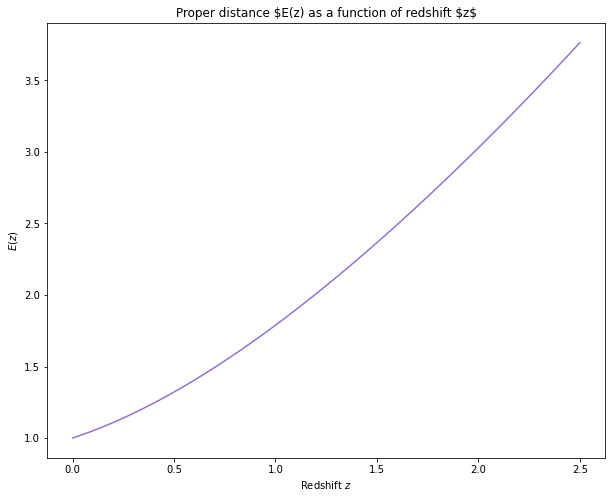

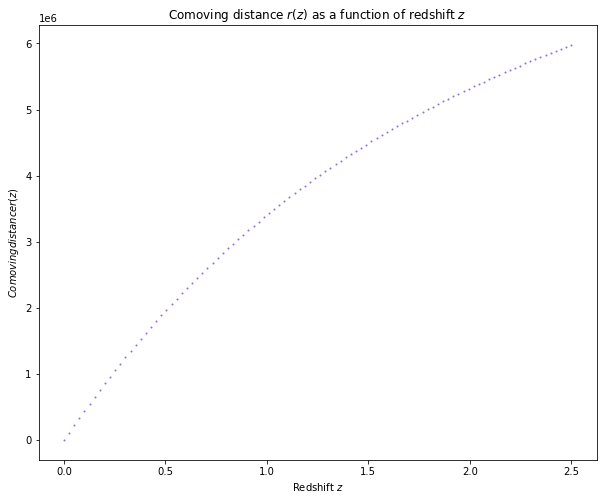

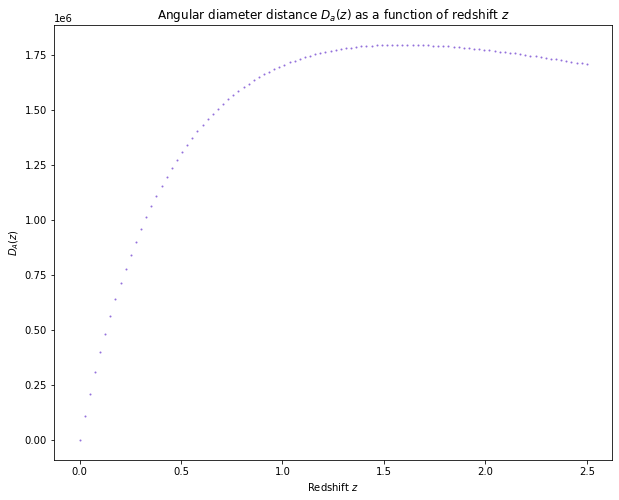

El tiempo que se demoró es 154.88890409469604 segundos


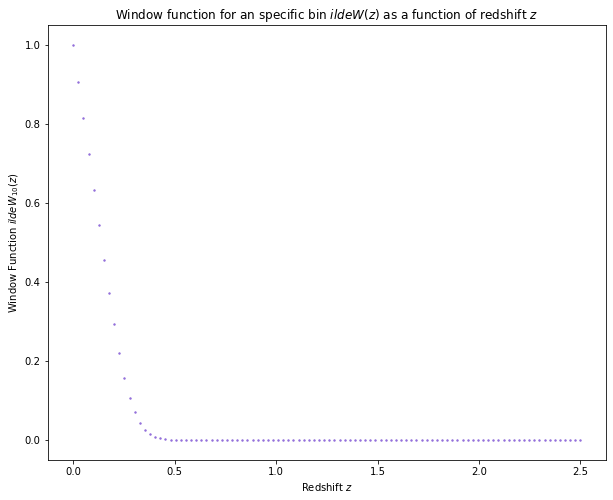

In [9]:
# using CAMB parameters
z_arr = np.linspace(0, 2.5, 100)

# Proper distance dependent on redshift plot
fig, ax = plt.subplots(1, 1, sharey='row', sharex='col', figsize=(10, 8))
ax.plot(z_arr, E_arb(z_arr, params_CAMB), label='$E(z)$', color='mediumpurple')
ax.set_xlabel('Redshift $z$')
ax.set_ylabel('$E(z)$')
ax.set_title('Proper distance $E(z) as a function of redshift $z$')
plt.show()

# Comoving distance to an object redshift z plot

fig, ax = plt.subplots(1, 1, sharey='row', sharex='col', figsize=(10, 8))
for z in z_arr:
    ax.scatter(z, r(z, params_CAMB), s=1.0, label='$r(z)$', color='mediumpurple')
ax.set_xlabel('Redshift $z$')
ax.set_ylabel('$Comoving distance r(z)$')
ax.set_title('Comoving distance $r(z)$ as a function of redshift $z$')
plt.show()

# Angular diameter distance to an object redshift z plot

fig, ax = plt.subplots(1, 1, sharey='row', sharex='col', figsize=(10, 8))
for z in z_arr:
    ax.scatter(z, D(z, params_CAMB), s=1.0, label='$D_A(z)$', color='mediumpurple')
ax.set_xlabel('Redshift $z$')
ax.set_ylabel('$D_A(z)$')
ax.set_title('Angular diameter distance $D_a(z)$ as a function of redshift $z$')
plt.show()


# Window function for an specific bin for redshift
start = time.time()
fig, ax = plt.subplots(1, 1, sharey='row', sharex='col', figsize=(10, 8))
for z in z_arr:
    ax.scatter(z, Window_F(z, 10), s=2.0, label='$Window Function(z)$',
               color='mediumpurple')
ax.set_xlabel('Redshift $z$')
ax.set_ylabel('Window Function $\tilde{W}_{10}(z)$')
ax.set_title('Window function for an specific bin $\tilde{W}(z)$ as a function of redshift $z$')
end = time.time()

print("El tiempo que se demoró es "+str(end-start)+" segundos")
plt.show()

# # Plotting matter power spectrum
# plt.figure(figsize=(8,5))
# for i, (redshift, line) in enumerate(zip(limits, ['-', '--'])):
#     plt.loglog(kh, pk[i, :], color='mediumpurple', ls = line)
#     plt.loglog(kh_nonlin, pk_nonlin[i, :], color='r', ls=line)
# plt.xlabel('k/h Mpc')
# plt.legend(['linear','non-linear'], loc='lower left')
# plt.title('Matter power at z=%s and z= %s'%tuple(limits))
# plt.show()

# # Interpolated matter power spectrum

# plt.figure(figsize=(8,5))
# k = np.exp(np.log(10)*np.linspace(-4, 2, 200))
# for z in z_bin_equi[0]:
#     plt.loglog(k, PK.P(z, k), color='mediumpurple')
# plt.xlim([1e-4,kmax])
# plt.xlabel('Wave-number k (h/Mpc)')
# plt.ylabel('$P_k, Mpc^3$')
# plt.legend(['z=%s'%z for z in z_bin_equi[0]])
# plt.show()

# # Cosmisc shear depending on l for especific set of i and j

# start_1 = time.time()
# fig, ax = plt.subplots(1, 1, sharey='row', sharex='col', figsize=(10, 8))
# l_toplot = [138, 194, 271, 378, 529, 739, 1031, 1440, 2012] # segun yo se plotea z_arr o la lista de los bins
# i, j = 2, 9 
# for l in l_toplot:
#     ax.scatter(l, C(l, i, j), color='mediumpurple')
# ax.set_xlabel('Multipole l')
# ax.set_ylabel(r'$C_{%s%s}^{\gamma\gamma(l)}$'%(str(i),str(j)))
# # ax.legend(['z=%s'%z for z in zplot])
# end_1 = time.time()

# print("El tiempo que se demoró es "+str(end_1-start_1)+" segundos")
# plt.show()



El tiempo que se demoró es 1428.379077911377 segundos


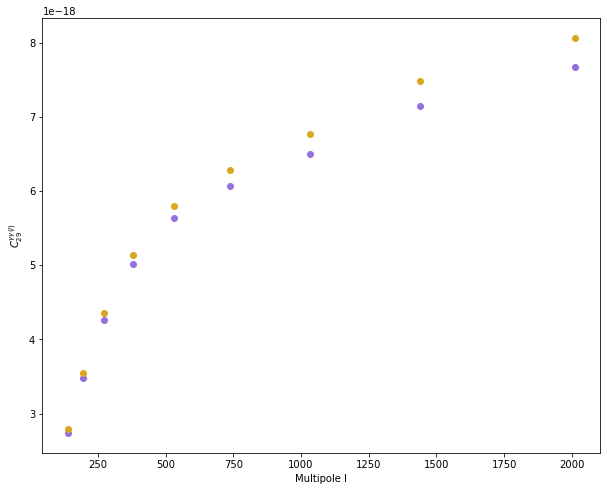

In [10]:
start_1 = time.time()
fig, ax = plt.subplots(1, 1, sharey='row', sharex='col', figsize=(10, 8))
l_toplot = [138, 194, 271, 378, 529, 739, 1031, 1440, 2012] # segun yo se plotea z_arr o la lista de los bins
i, j = 2, 9 
for l in l_toplot:
    ax.scatter(l, C(l, 1, 10), color='mediumpurple', label='$C_{1,10}$')
    ax.scatter(l, C(l, 2, 9), color='goldenrod', label = '$C_{2,9}$')
ax.set_xlabel('Multipole l')
ax.set_ylabel(r'$C_{%s%s}^{\gamma\gamma(l)}$'%(str(i),str(j)))
# ax.legend(['z=%s'%z for z in zplot])
end_1 = time.time()

print("El tiempo que se demoró es "+str(end_1-start_1)+" segundos")
plt.show()

IndexError: arrays used as indices must be of integer (or boolean) type

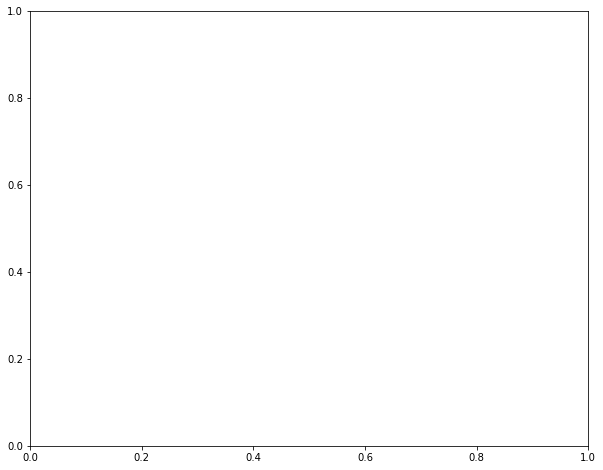

In [11]:
start_2 = time.time()
fig, ax = plt.subplots(1, 1, sharey='row', sharex='col', figsize=(10, 8))
l_toplot = [138, 194, 271, 378, 529, 739, 1031, 1440, 2012] # segun yo se plotea z_arr o la lista de los bins
i = np.linspace(1,10,10)
j = i = np.linspace(1,10,10)
for l in l_toplot:
    ax.scatter(l, C(l, i, j), color='mediumpurple')
ax.set_xlabel('Multipole l')
ax.set_ylabel(r'$C_{%s%s}^{\gamma\gamma(l)}$'%(str(i),str(j)))
# ax.legend(['z=%s'%z for z in zplot])
end_2 = time.time()

print("El tiempo que se demoró es "+str(end_2-start_2)+" segundos")
plt.show()